In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from keras.applications import VGG19 as PTM
from tensorflow.keras import backend as bk
import numpy as np
from tensorflow import keras
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/train'
test_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/test'
gt_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/GroundTruth/Gt.csv'

In [3]:
target_size= (224,224)
batch_size = 5
epochs = 10 * 3

In [4]:
test_dataset = []
file_ids = []
testData =  glob.glob('{}/*.jpg'.format(test_path))
for data in testData:
  img = tf.keras.preprocessing.image
  image = img.load_img(data, color_mode='rgb', target_size= target_size)
  image = np.array(image)
  file_id = os.path.basename(data).replace('.jpg', '')
  test_dataset.append(image)
  file_ids.append(int(file_id))

In [5]:
file_ids[10]

1

In [6]:
imageDataGen = ImageDataGenerator(rescale= 1./ 255,
                                 shear_range= 0.2,
                                 zoom_range=0.2, 
                                 horizontal_flip=True, 
                                 validation_split=0.25,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 fill_mode="nearest")



train_generator = imageDataGen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = imageDataGen.flow_from_directory(
    train_path, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 444 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'Mask': 0, 'NoMask': 1}

In [8]:
pd.DataFrame(train_generator.classes, columns=['Classes']).value_counts()

Classes
0          360
1           84
dtype: int64

In [9]:
pd.DataFrame(validation_generator.classes, columns=['Classes']).value_counts()

Classes
0          120
1           27
dtype: int64

In [10]:
ptm = PTM(input_shape=tuple(list(target_size)+[3]),
            weights='imagenet', 
            include_top=False, pooling='avg')
ptm.trainable = False 

In [11]:
ptm.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
model.add(ptm)
model.add(Flatten())
model.add(Dense(1024, activation=('relu'), input_dim=512))
model.add(Dense(512,activation='relu')) 
model.add(Dense(256,activation='relu')) 
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
with tf.device('/device:GPU:0'):
  training_history = model.fit(train_generator, validation_data=validation_generator ,epochs=epochs, verbose=1) #,steps_per_epoch=len(train_generator), validation_data=validation_generator, validation_steps=len(validation_generator)

Epoch 1/30
89/89 [==============================] - 14s 125ms/step - loss: 0.5622 - accuracy: 0.7694 - val_loss: 0.4742 - val_accuracy: 0.8163
Epoch 2/30
89/89 [==============================] - 10s 112ms/step - loss: 0.5050 - accuracy: 0.7789 - val_loss: 0.4624 - val_accuracy: 0.8163
Epoch 3/30
89/89 [==============================] - 10s 111ms/step - loss: 0.3816 - accuracy: 0.8393 - val_loss: 0.4298 - val_accuracy: 0.8367
Epoch 4/30
89/89 [==============================] - 10s 112ms/step - loss: 0.4593 - accuracy: 0.7812 - val_loss: 0.4845 - val_accuracy: 0.8231
Epoch 5/30
89/89 [==============================] - 10s 112ms/step - loss: 0.4227 - accuracy: 0.8409 - val_loss: 0.4485 - val_accuracy: 0.8231
Epoch 6/30
89/89 [==============================] - 10s 112ms/step - loss: 0.3348 - accuracy: 0.8586 - val_loss: 0.5342 - val_accuracy: 0.8163
Epoch 7/30
89/89 [==============================] - 10s 111ms/step - loss: 0.3512 - accuracy: 0.8509 - val_loss: 0.5374 - val_accuracy: 0.8299

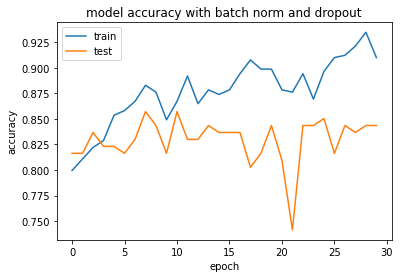

In [30]:
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy with batch norm and dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

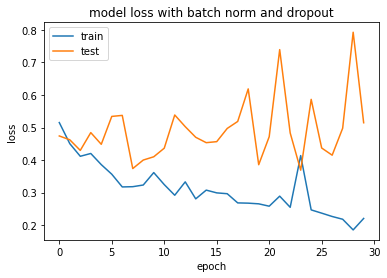

In [17]:
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss with batch norm and dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
val_dataset_lables = train_generator.labels
#val_dataset_lables

In [19]:
classes = train_generator.class_indices
classes = classes.keys()
classes = list(classes)
classes

['Mask', 'NoMask']

In [20]:
pred_test_result = []
for file_id, img in zip(file_ids, test_dataset):
  exp_img = np.expand_dims(img, axis=0)
  val_dataset_pred = model.predict(exp_img)
  pred_val = np.argmax(val_dataset_pred)
  pred_val_lable = classes[pred_val]
  val_dataset_pred_lable = None
  if pred_val_lable == 'Mask':
    val_dataset_pred_lable = 1
  else:
    val_dataset_pred_lable = 0
  result = [file_id,  val_dataset_pred_lable, pred_val_lable]
  #print(val_dataset_pred)
  print(result)
  pred_test_result.append(result)
  #print("\n")

[41, 1, 'Mask']
[39, 1, 'Mask']
[27, 1, 'Mask']
[35, 1, 'Mask']
[45, 1, 'Mask']
[38, 0, 'NoMask']
[32, 1, 'Mask']
[31, 1, 'Mask']
[29, 1, 'Mask']
[9, 1, 'Mask']
[1, 1, 'Mask']
[26, 1, 'Mask']
[24, 1, 'Mask']
[21, 1, 'Mask']
[28, 1, 'Mask']
[7, 1, 'Mask']
[42, 1, 'Mask']
[44, 0, 'NoMask']
[25, 1, 'Mask']
[12, 1, 'Mask']
[6, 1, 'Mask']
[43, 1, 'Mask']
[0, 1, 'Mask']
[10, 1, 'Mask']
[19, 1, 'Mask']
[4, 1, 'Mask']
[3, 1, 'Mask']
[18, 1, 'Mask']
[15, 1, 'Mask']
[37, 0, 'NoMask']
[14, 1, 'Mask']
[16, 1, 'Mask']
[23, 1, 'Mask']
[2, 1, 'Mask']
[11, 1, 'Mask']
[17, 1, 'Mask']
[30, 0, 'NoMask']
[20, 1, 'Mask']
[40, 1, 'Mask']
[13, 1, 'Mask']
[22, 1, 'Mask']
[33, 1, 'Mask']
[34, 1, 'Mask']
[8, 1, 'Mask']
[36, 0, 'NoMask']
[5, 1, 'Mask']


In [21]:
pred_test_result_df = pd.DataFrame(pred_test_result, columns=['file_id', 'label', 'label_value'])
pred_test_result_df.sort_values(by='file_id')

,file_id,label,label_value
22,0,1,Mask
10,1,1,Mask
33,2,1,Mask
26,3,1,Mask
25,4,1,Mask
45,5,1,Mask
20,6,1,Mask
15,7,1,Mask
43,8,1,Mask
9,9,1,Mask


In [22]:
subbmit_m1 = pred_test_result_df.drop(['label_value'], axis=1)
subbmit_m1.to_csv('HDFC_Hackthon_Submit_9.csv', index=False)

In [23]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2, MobileNetV3Large

In [24]:
mn = MobileNetV3Small(input_shape=tuple(list(target_size)+[3]),
            weights='imagenet', 
            include_top=False, pooling='avg')
mn.trainable = False

6701056/6698480 [==============================] - 0s 0us/step


In [25]:
mn.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [26]:
model_mn = Sequential()
model_mn.add(mn)
model_mn.add(Flatten())
model_mn.add(Dense(1024, activation=('relu'), input_dim=512))
model_mn.add(Dense(512,activation='relu')) 
model_mn.add(Dense(256,activation='relu')) 
model_mn.add(Dropout(.3))
model_mn.add(Dense(128,activation='relu'))
model_mn.add(Dropout(.2))
model_mn.add(Dense(2,activation='softmax'))

In [27]:
model_mn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [28]:
model_mn.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
with tf.device('/device:GPU:0'):
  training_history_mn = model_mn.fit(train_generator,steps_per_epoch=len(train_generator) ,epochs=epochs, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1)

Epoch 1/30
89/89 [==============================] - 14s 117ms/step - loss: 0.6565 - accuracy: 0.7426 - val_loss: 0.4797 - val_accuracy: 0.8163
Epoch 2/30
89/89 [==============================] - 9s 102ms/step - loss: 0.4870 - accuracy: 0.8134 - val_loss: 0.4876 - val_accuracy: 0.8163
Epoch 3/30
89/89 [==============================] - 9s 102ms/step - loss: 0.5208 - accuracy: 0.8101 - val_loss: 0.5418 - val_accuracy: 0.8163
Epoch 4/30
89/89 [==============================] - 9s 101ms/step - loss: 0.5143 - accuracy: 0.8075 - val_loss: 0.4770 - val_accuracy: 0.8163
Epoch 5/30
89/89 [==============================] - 9s 101ms/step - loss: 0.4972 - accuracy: 0.8133 - val_loss: 0.5114 - val_accuracy: 0.8163
Epoch 6/30
89/89 [==============================] - 9s 100ms/step - loss: 0.4773 - accuracy: 0.8386 - val_loss: 0.4820 - val_accuracy: 0.8163
Epoch 7/30
89/89 [==============================] - 9s 100ms/step - loss: 0.4606 - accuracy: 0.8344 - val_loss: 0.4896 - val_accuracy: 0.8163
Epoch

In [32]:
pred_test_result_mn = []
for file_id, img in zip(file_ids, test_dataset):
  exp_img = np.expand_dims(img, axis=0)
  val_dataset_pred = model.predict(exp_img)
  pred_val = np.argmax(val_dataset_pred)
  pred_val_lable = classes[pred_val]
  val_dataset_pred_lable = None
  if pred_val_lable == 'Mask':
    val_dataset_pred_lable = 1
  else:
    val_dataset_pred_lable = 0
  result = [file_id,  val_dataset_pred_lable, pred_val_lable]
  print(result)
  pred_test_result_mn.append(result)
  

[41, 1, 'Mask']
[39, 1, 'Mask']
[27, 1, 'Mask']
[35, 1, 'Mask']
[45, 1, 'Mask']
[38, 0, 'NoMask']
[32, 1, 'Mask']
[31, 1, 'Mask']
[29, 1, 'Mask']
[9, 1, 'Mask']
[1, 1, 'Mask']
[26, 1, 'Mask']
[24, 1, 'Mask']
[21, 1, 'Mask']
[28, 1, 'Mask']
[7, 1, 'Mask']
[42, 1, 'Mask']
[44, 0, 'NoMask']
[25, 1, 'Mask']
[12, 1, 'Mask']
[6, 1, 'Mask']
[43, 1, 'Mask']
[0, 1, 'Mask']
[10, 1, 'Mask']
[19, 1, 'Mask']
[4, 1, 'Mask']
[3, 1, 'Mask']
[18, 1, 'Mask']
[15, 1, 'Mask']
[37, 0, 'NoMask']
[14, 1, 'Mask']
[16, 1, 'Mask']
[23, 1, 'Mask']
[2, 1, 'Mask']
[11, 1, 'Mask']
[17, 1, 'Mask']
[30, 0, 'NoMask']
[20, 1, 'Mask']
[40, 1, 'Mask']
[13, 1, 'Mask']
[22, 1, 'Mask']
[33, 1, 'Mask']
[34, 1, 'Mask']
[8, 1, 'Mask']
[36, 0, 'NoMask']
[5, 1, 'Mask']


In [33]:
pred_test_result_mn_df = pd.DataFrame(pred_test_result_mn, columns=['file_id', 'label', 'label_value'])
pred_test_result_mn_df.sort_values(by='file_id')

,file_id,label,label_value
22,0,1,Mask
10,1,1,Mask
33,2,1,Mask
26,3,1,Mask
25,4,1,Mask
45,5,1,Mask
20,6,1,Mask
15,7,1,Mask
43,8,1,Mask
9,9,1,Mask


In [34]:
subbmit_m2 = pred_test_result_mn_df.drop(['label_value'], axis=1)
subbmit_m2.to_csv('HDFC_Hackthon_Submit_10.csv', index=False)